In [1]:

from langchain_aws import ChatBedrock
from langchain_core.messages import HumanMessage

import requests
from bs4 import BeautifulSoup
import lxml
import boto3


import json
from datetime import datetime
from fuzzywuzzy import fuzz
import pandas as pd
import warnings
warnings.filterwarnings('ignore')



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
llm_model = "anthropic.claude-3-sonnet-20240229-v1:0"
bedrock_client = boto3.client(service_name='bedrock-runtime')
temperature = 0
benchmark_datetime = datetime.now()

In [3]:
function_descriptions = {
  "prompt_craft_instructions": [
    "For this task, you need to examine the code for security vulnerabilities, generate fixes for any vulnerabilities found, and provide comments explaining the issues and fixes. Your response should be structured as a JSON object with the following keys:",
    {
      "vulnerability found": "A string 'Yes' if a vulnerability is found in the code, or 'No' if no vulnerability is found.", 
      "vulnerability": "A string describing the type of vulnerability found, or 'None' if no vulnerability is found.",
      "vulnerable code": "A string containing the vulnerable code, or 'None' if no vulnerability is found.",
      "code fix": "A string containing a code fix for the vulnerability, or 'None' if no vulnerability is found.", 
      "comment": "A comment describing the issue and fix, or 'No issues found' if no vulnerability is found."
    },
    "Please provide the JSON output without any special formatting, code blocks, or triple backticks."

  ]
}

system_prompt = json.dumps(function_descriptions, separators=(',', ':'))


In [4]:
def static_analysis_tool(code):
    response = bedrock_client.invoke_model(
        modelId=llm_model,
        body=json.dumps({
            "messages": [{"role": "user", "content": code}],
            "system": system_prompt,
            "temperature": temperature,
            "anthropic_version": "bedrock-2023-05-31",    
            "max_tokens": 4096
        })
    )
    response_body = json.loads(response['body'].read())
   # print(response_body)
    first_response = response_body['content'][0]['text']
   # print(first_response)

    return first_response


In [5]:
# Function to fetch web content
def fetch_webpage_content(url):
    response = requests.get(url)
    return response.text

In [6]:
# Function to fetch and parse xml
def fetch_and_parse_xml(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    return soup

In [7]:
def compare_results(analysis_result, metadata):
    # Check if a vulnerability was found
    vuln_found = analysis_result['vulnerability found'].lower() == 'yes'
    # Check if the vulnerability matches the one in the metadata using fuzzy matching
    vuln_matches = fuzz.partial_ratio(metadata.category.string.lower(), analysis_result['vulnerability'].lower()) > 80
    # Check if the metadata indicates a vulnerability exists
    metadata_vuln_exists = metadata.vulnerability.string.lower() == 'true'
    # Get the actual vulnerability types
    actual_vuln_type = analysis_result['vulnerability']
    expected_vuln_type = metadata.category.string

    # Combine analysis_result and metadata into one dictionary
    combined_result = {
        'vulnerability_found': vuln_found,
        'vulnerability_type_matches': vuln_matches,
        'metadata_vulnerability_exists': metadata_vuln_exists,
        'expected_vuln_type': expected_vuln_type
    }
    
    # Add all fields from the analysis_result to the combined_result
    combined_result.update(analysis_result)

    # Return the combined result
    return combined_result


In [8]:
def construct_url(base_url, test_case_number, file_extension):
    # Construct the URLs for the Java file and the metadata XML file for this test case
    url = f"{base_url}{test_case_number}.{file_extension}"
    return url

In [13]:
def run_test_case(test_case_number):
    # Set the base URLs for the Java files and the metadata XML files
    base_java_url = "https://raw.githubusercontent.com/OWASP-Benchmark/BenchmarkJava/master/src/main/java/org/owasp/benchmark/testcode/BenchmarkTest"
    base_xml_url = "https://raw.githubusercontent.com/OWASP-Benchmark/BenchmarkJava/master/src/main/java/org/owasp/benchmark/testcode/BenchmarkTest"

    # Construct the URLs for the Java file and the metadata XML file for this test case
    java_url = construct_url(base_java_url, test_case_number, "java")
    xml_url = construct_url(base_xml_url, test_case_number, "xml")

    # Fetch the Java code and the metadata
    code = fetch_webpage_content(java_url)
    metadata = fetch_and_parse_xml(xml_url)
    # print(code)

    # Run the static analysis tool and deserialize the result from JSON to a dictionary
    analysis_result_json = static_analysis_tool(code)
    # print("analysis_result_json:", analysis_result_json)
    analysis_result = json.loads(analysis_result_json, strict=False)


    # Run the comparison function
    result = compare_results(analysis_result, metadata)

    return result

In [17]:
import pandas as pd

def run_all_test_cases(num_test_cases):
    # Create an empty DataFrame to store the results with the required columns
    df = pd.DataFrame()
    # Loop through all the test case numbers
    for i in range(1, num_test_cases + 1):
        # Format the test case number as a 5-digit string (e.g., '00001', '00002', etc.)
        test_case_number = f"{i:05d}"
        print("Running test: " + str(test_case_number))

        # Run the test case and get the result
        result_dict = run_test_case(test_case_number)

        # Print the result_dict for debugging
        #print(f"Result dictionary for test case {test_case_number}: {result_dict}")

        # Convert the result dictionary to a DataFrame
        result_df = pd.DataFrame([result_dict])

        # Print the result_df for debugging
        #print(f"DataFrame for test case {test_case_number}:")
        #print(result_df)

        # Concatenate the result to the DataFrame
        df = pd.concat([df, result_df], ignore_index=True)

    # Print the final DataFrame for debugging
    print("Final DataFrame:")
    print(df)

    # Save the DataFrame to a CSV file
    file_name = "results-" + llm_model + "-temperature" + str(temperature) + "-benchmark-datetime-" + str(benchmark_datetime) + ".csv"
    df.to_csv(file_name, index=False)

    return df


In [18]:
def analyze_results(csv_path):
    # Load the results from the CSV file
    df = pd.read_csv(csv_path)

    # Calculate the confusion matrix components
    TP = ((df['vulnerability_found'] == True) & (df['metadata_vulnerability_exists'] == True)).sum()
    TN = ((df['vulnerability_found'] == False) & (df['metadata_vulnerability_exists'] == False)).sum()
    FP = ((df['vulnerability_found'] == True) & (df['metadata_vulnerability_exists'] == False)).sum()
    FN = ((df['vulnerability_found'] == False) & (df['metadata_vulnerability_exists'] == True)).sum()

    return TP, TN, FP, FN

In [ ]:
num_test_cases = 1000
run_all_test_cases(num_test_cases)

file_name = "results-" + llm_model + "-temperature" + str(temperature) + "-benchmark-datetime-" + str(benchmark_datetime) + ".csv"
TP, TN, FP, FN = analyze_results(file_name)
print(f'True Positives: {TP}')
print(f'True Negatives: {TN}')
print(f'False Positives: {FP}')
print(f'False Negatives: {FN}')

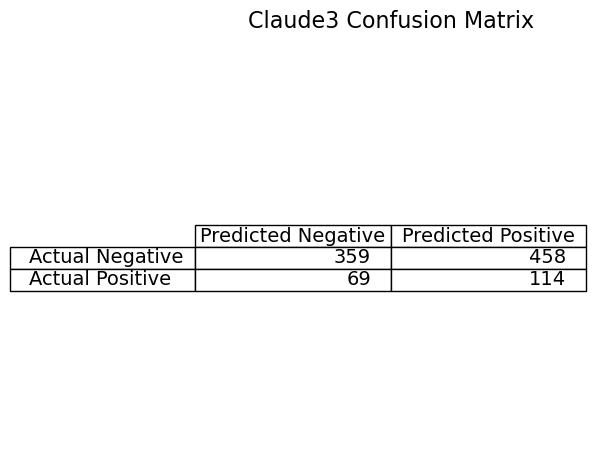

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the confusion matrix
confusion_matrix = np.array([[FP, TP], [FN, TN]])

# Labels for the actual and predicted classes
actual_labels = ['Actual Negative', 'Actual Positive']
predicted_labels = ['Predicted Negative', 'Predicted Positive']

# Create a figure and axis
fig, ax = plt.subplots()

# Create a table with the confusion matrix data
table = ax.table(cellText=confusion_matrix, rowLabels=actual_labels, colLabels=predicted_labels, loc='center')

# Adjust the table properties
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)

# Set the title and axis labels
ax.set_title('Claude-3-Sonnet Confusion Matrix', fontsize=16, pad=20)
ax.set_axis_off()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

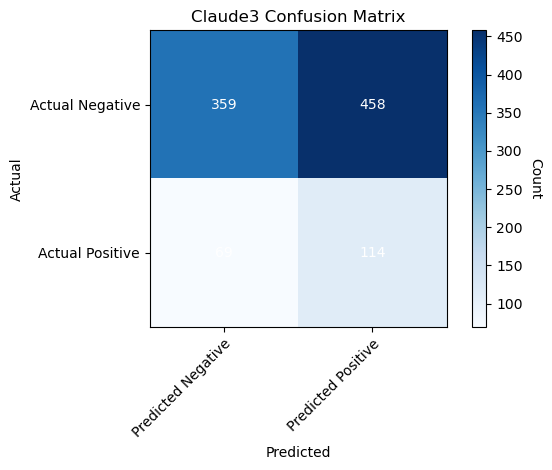

In [21]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix as a heatmap
im = ax.imshow(confusion_matrix, cmap='Blues')

# Set the x and y ticks
ax.set_xticks(np.arange(len(predicted_labels)))
ax.set_yticks(np.arange(len(actual_labels)))
ax.set_xticklabels(predicted_labels)
ax.set_yticklabels(actual_labels)

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Loop over the data and create text annotations
for i in range(len(actual_labels)):
    for j in range(len(predicted_labels)):
        text = ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='white')

# Set the title and axis labels
ax.set_title('Claude-3-Sonnet Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Count', rotation=-90, va='bottom')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


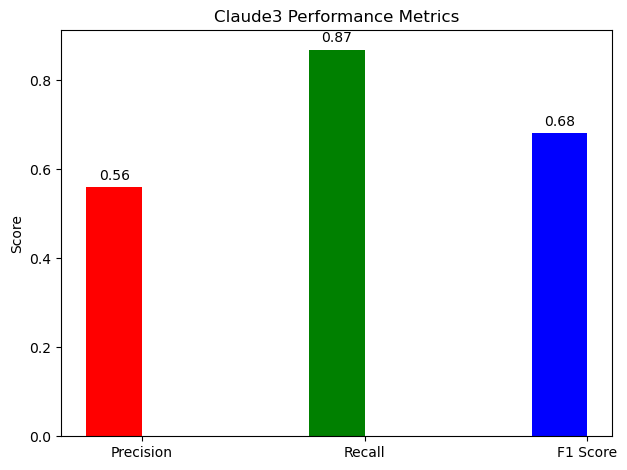

In [23]:
import matplotlib.pyplot as plt
import numpy as np



# Calculate Precision, Recall, and F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a figure and axis
fig, ax = plt.subplots()

# Set the bar width and positions
bar_width = 0.25
index = np.arange(3)

# Plot the bars
bars = ax.bar(index, [precision, recall, f1_score], bar_width, color=['r', 'g', 'b'])

# Set the x-axis tick labels
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Precision', 'Recall', 'F1 Score'])

# Set the y-axis label
ax.set_ylabel('Score')

# Add value labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

# Set the title
ax.set_title('Claude-3-Sonnet Performance Metrics')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
